# Shopping QnA

- Author: [Mark](https://github.com/obov)
- Design: []()
- Peer Review:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/08-Embeeding/08-MultiModalEmbeddings.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/08-Embeeding/08-MultiModalEmbeddings.ipynb)

## Overview

### Table of Contents

- [Overview](#overview)
- [Environement Setup](#environment-setup)
- [Data Augmentation](#data-augmentation)
- [Storing embedded values in VectorDB](#storing-embedded-values-in-vectordb)
- [Vector Search](#vector-search)
- [Multimodal RAG Chatbot](#multimodal-rag-chatbot)

### References

- [Bedrock Multimodal RAG Chatbot](https://aws.amazon.com/ko/blogs/tech/bedrock-multimodal-rag-chatbot/)
- [Public Multimodal RAG Chatbot](https://github.com/hi-space/public-multimodal-rag-chatbot/tree/main)
- [Kream Product BLIP Captions](https://huggingface.co/datasets/hahminlew/kream-product-blip-captions)
- [LangChain Multimodal Inputs](https://python.langchain.com/docs/how_to/multimodal_inputs/)

---


## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**

- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials.
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.


In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "datasets",
        "langchain",
        "langchain_core",
        "langchain_openai",
        "langchain_experimental",
        "langchain_chroma",
        "open_clip_torch",
        "torch",
    ],
    verbose=False,
    upgrade=False,
)


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "Your API KEY",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "06-MultiModal/11-ShoppingQnA",
    }
)

Environment variables have been set successfully.


In [4]:
# Alternatively, one can set environmental variables with load_dotenv
from dotenv import load_dotenv


load_dotenv(override=True)

True

## Data Augmentation

To generate a dataset suitable for a virtual shopping mall’s product database using the KREAM Product BLIP Captions dataset, we need to perform data augmentation.


In [5]:
from datasets import load_dataset
import os

# Serialize dictionary to pickle file

os.makedirs("../data", exist_ok=True)
os.makedirs("../data/11-ShoppingQnA-cache", exist_ok=True)

# Load dataset
dataset = load_dataset(
    "hahminlew/kream-product-blip-captions", cache_dir="../data/11-ShoppingQnA-cache"
)

print(dataset)

Old caching folder ../data/11-ShoppingQnA-cache/hahminlew___kream-product-blip-captions/default/0.0.0/54f0f63fca385f12052fdc318093de7a65fbaf2a for dataset kream-product-blip-captions exists but no data were found. Removing it. 


Generating train split:   0%|          | 0/14904 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 14904
    })
})


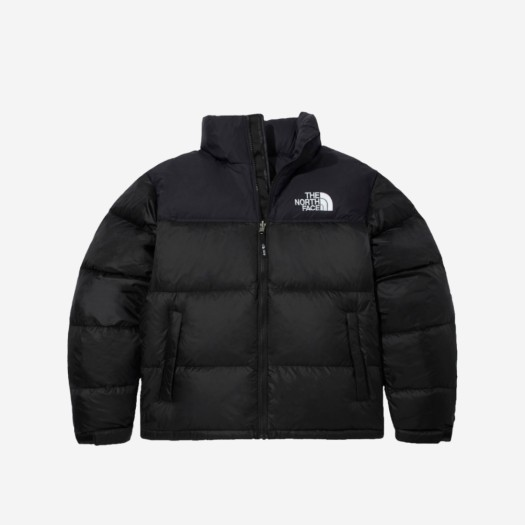

outer, The North Face 1996 Eco Nuptse Jacket Black, a photography of the north face black down jacket


In [6]:
from IPython.display import display

display(dataset["train"][0]["image"])
print(dataset["train"][0]["text"])

Dataset({
    features: ['image', 'text'],
    num_rows: 200
})
200


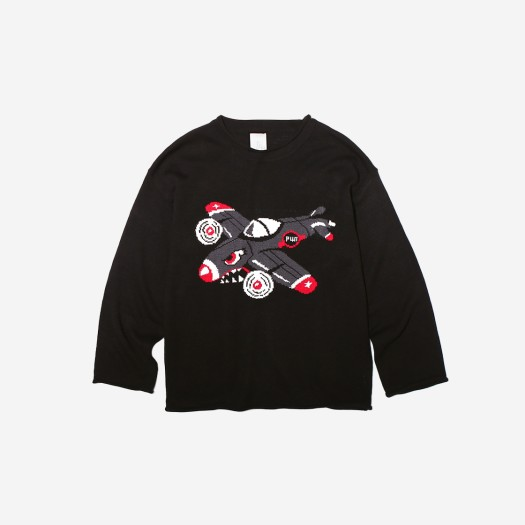

top,  P40 Knit Black, a photography of a black long sleeved shirt with a motorcycle motif


In [7]:
# Sample Size
SAMPLE_SIZE = 200

# Randomly sampling
sampled_dataset = dataset["train"].shuffle(seed=42).select(range(SAMPLE_SIZE))

print(sampled_dataset)
print(len(sampled_dataset))
display(sampled_dataset[0]["image"])
print(sampled_dataset[0]["text"])

{'resized_image': <PIL.Image.Image image mode=RGB size=262x262 at 0x16A078490>, 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=525x525 at 0x16A0FBFD0>, 'text': 'top,  P40 Knit Black, a photography of a black long sleeved shirt with a motorcycle motif'}


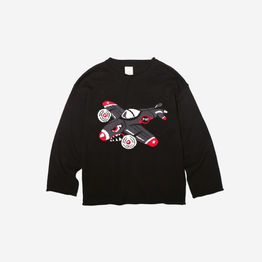

In [8]:
from PIL import Image


def resize_image(image, scale_factor):
    """
    이미지의 해상도를 원하는 비율로 줄이는 함수.

    Args:
        image (PIL.Image.Image): PIL 이미지 객체.
        scale_factor (float): 해상도를 줄이는 비율 (0 ~ 1).

    Returns:
        PIL.Image.Image: 해상도가 줄어든 PIL 이미지 객체.
    """
    if not (0 < scale_factor <= 1):
        raise ValueError("scale_factor는 0보다 크고 1 이하이어야 합니다.")

    # get original size
    original_width, original_height = image.size

    # calculate new size
    new_width = int(original_width * scale_factor)
    new_height = int(original_height * scale_factor)

    # resize image
    resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    return resized_image


image_resized_dataset = [
    {"resized_image": resize_image(item["image"], 0.5), **item}
    for item in sampled_dataset
]

print(image_resized_dataset[0])
display(image_resized_dataset[0]["resized_image"])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=525x525 at 0x16A0FBFD0>, 'resized_image': <PIL.Image.Image image mode=RGB size=262x262 at 0x16A078490>, 'type': 'top', 'name': '  P40 Knit Black', 'summary': ' a photography of a black long sleeved shirt with a motorcycle motif'}


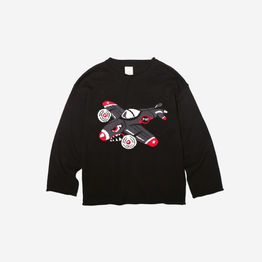

In [9]:
def sample_item_process(item):
    splited = item["text"].split(",")
    return {
        "image": item["image"],
        "resized_image": item["resized_image"],
        "type": splited[0],
        "name": splited[1],
        "summary": splited[2],
    }


processed_dataset = [sample_item_process(item) for item in image_resized_dataset]
print(processed_dataset[0])
display(processed_dataset[0]["resized_image"])

In [10]:
# Json Data Augmentation

import base64
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from io import BytesIO
import json
from langchain_core.output_parsers import BaseOutputParser


# Create model
llm_multimodal = ChatOpenAI(model_name="gpt-4o")


# PIL Image to Base64
def pil_image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def process_item_to_prompt(item):
    image_data = pil_image_to_base64(item["resized_image"])
    item["base64_image"] = image_data
    item["base64_image_url"] = f"data:image/jpeg;base64,{image_data}"
    type = item["type"]
    name = item["name"]

    message = HumanMessage(
        content=[
            {
                "type": "text",
                "text": "Look at the image and properties of this product and describe it\n"
                "Format the response as a JSON object with four keys: 'summary', 'image_summary' and 'tags'.\n"
                "- 'summary': Summary of product form based on appearance in a sentence\n"
                "- 'image_summary': Describe this image of product based on its type, color, material, pattern, and features.\n"
                "- 'tags':  An array of strings representing key features or properties that can represent color, pattern, material, type of the product.\n",
            },
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
            },
            {
                "type": "text",
                "text": f"The product is a type of {type} and name is {name}.",
            },
        ],
    )

    return message


class JsonOutputParser(BaseOutputParser[dict]):
    def parse(self, text: str) -> dict:
        text = text[7:-3]
        return json.loads(text)


response = (llm_multimodal | JsonOutputParser()).invoke(
    [process_item_to_prompt(processed_dataset[0])]
)
print(response)


# Use batch to process multiple messages
response = (llm_multimodal | JsonOutputParser()).batch(
    [
        [process_item_to_prompt(processed_dataset[1])],
        [process_item_to_prompt(processed_dataset[2])],
    ]
)
print(response[0])
print(response[1])

{'summary': 'This is a black knit sweater featuring a graphic design on the front.', 'image_summary': 'The product is a long-sleeved black knit sweater with a colorful airplane graphic in red, white, and gray on the front. It appears to be made of a soft material.', 'tags': ['black', 'knit', 'sweater', 'graphic', 'airplane', 'long sleeve']}
{'summary': 'This is a black, sleeveless, quilted down gilet with a high collar and front pockets.', 'image_summary': 'The product is a black, sleeveless gilet made from quilted material, featuring two front pockets, a high collar, and button closure. It appears to be designed for warmth and style.', 'tags': ['black', 'quilted', 'down gilet', 'sleeveless', 'high collar', 'button closure']}
{'summary': 'The product is a pair of navy blue cargo shorts with a sporty design.', 'image_summary': 'This image shows a pair of navy blue cargo shorts made from a durable material, featuring zippered pockets, a belt, and a GORE-TEX tag. The shorts have a plain p

In [11]:
# Description Data Augmentation

from langchain_core.output_parsers import StrOutputParser

json_augmentation_data = {**processed_dataset[0], **response[0]}


def serialize_item(item):
    result = json.dumps(
        {
            k: v
            for k, v in item.items()
            if k != "image"
            and k != "resized_image"
            and k != "base64_image_url"
            and k != "base64_image"
        },
        indent=4,
    )
    return result


def json_augmentation_item_to_prompt(item):

    message = HumanMessage(
        content=[
            {
                "type": "text",
                "text": "look at the image of the product and properties and write a detailed and narrative product description\n"
                "Keep a lively tone and use a hook to make users want to buy the product.\n"
                "Do not include tags or other descriptions.\n"
                "\n"
                "Here are the properties of the product\n"
                f"{serialize_item(item)}\n",
            },
            {
                "type": "image_url",
                "image_url": {"url": item["base64_image_url"]},
            },
        ],
    )

    return message


response = (llm_multimodal | StrOutputParser()).invoke(
    [json_augmentation_item_to_prompt(json_augmentation_data)]
)
print(response)

Introducing the P40 Knit Black, your ultimate companion for conquering both the urban jungle and the great outdoors! This sleek, sleeveless quilted down gilet is more than just a style statement; it's your personal cocoon of warmth and elegance.

Picture this: a chilly morning, a crisp breeze, and you, effortlessly stylish in your P40 Knit Black. Its high collar is not just a fashion-forward detail but a snug shield against the elements. The button closure adds a touch of sophistication, ensuring you’re wrapped in comfort without compromising on flair.

Slide your hands into the convenient front pockets, perfect for stashing essentials or keeping your hands toasty. The black quilted design is timeless, offering versatility that matches every outfit, from casual jeans to your favorite athleisure wear.

Don’t let cold weather cramp your style. Embrace the P40 Knit Black and stride out with confidence, knowing you're covered in both warmth and panache. It’s not just a gilet; it’s your new

In [12]:
# Combine Data Augmentation Chains

from langchain_core.runnables import (
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from pprint import pprint

augmentation_multimodal_chain = (
    RunnableParallel(  # JSON Augmentation
        {
            "processed": RunnablePassthrough(),
            "json_augmented": RunnableLambda(lambda x: [process_item_to_prompt(x)])
            | llm_multimodal
            | JsonOutputParser(),
        }
    )
    | RunnableLambda(  # Merge JSON Augmentation and Processed Data
        lambda x: {
            **x["processed"],
            **x["json_augmented"],
        }
    )
    | RunnableParallel(  # Description Augmentation
        {
            "process_and_json_augmented": lambda x: x,
            "description_augmented": RunnableLambda(
                lambda x: [json_augmentation_item_to_prompt(x)]
            )
            | llm_multimodal
            | StrOutputParser(),
        }
    )
    | RunnableLambda(  # Merge Description Augmentation and Processed Data
        lambda x: {
            **x["process_and_json_augmented"],
            "description": x["description_augmented"],
        }
    )
)

augmentation_dataset = augmentation_multimodal_chain.batch(processed_dataset)

print(len(augmentation_dataset))
pprint(
    {
        k: v
        for k, v in augmentation_dataset[0].items()
        if k != "base64_image" and k != "base64_image_url"
    }
)

200
{'description': 'Introducing the P40 Knit Black—your new wardrobe hero that’s '
                'ready to take flight! 🚀 This isn’t just any black top; it’s a '
                'statement piece that combines comfort and style with a touch '
                'of adventure. Made from a cozy knit fabric, this long-sleeve '
                'top promises warmth and versatility, perfect for those chilly '
                'days or layered looks.\n'
                '\n'
                'The centerpiece? A vibrant airplane graphic that soars with '
                'red and white accents, making your outfit truly '
                "unforgettable. Whether you're an aviation enthusiast or just "
                'love a unique design, this top has got you covered. Pair it '
                'with jeans for a casual look or dress it up with a skirt for '
                'an unexpected twist. \n'
                '\n'
                'Ready to elevate your style? The P40 Knit Black awaits your '
   

## Storing embedded values in VectorDB


In [13]:
database = [
    {"id": str(index), **item} for index, item in enumerate(augmentation_dataset)
]

In [14]:
# Check Device Availability
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [15]:
# Define Some Utility Functions
import base64
import re


def is_base64(s: str) -> bool:
    """
    Check if the string is a valid Base64 encoded string.
    """
    if not isinstance(s, str) or len(s) % 4 != 0:
        return False

    base64_pattern = re.compile(r"^[A-Za-z0-9+/]+={0,2}$")
    if not base64_pattern.match(s):
        return False

    try:
        decoded = base64.b64decode(s, validate=True)
        return base64.b64encode(decoded).decode("utf-8") == s
    except Exception:
        return False


def base64_to_pil(base64_str: str) -> Image.Image:
    """
    Convert a Base64-encoded string to a PIL.Image.Image object.

    Args:
        base64_str (str): A Base64-encoded image string.

    Returns:
        PIL.Image.Image: The converted PIL Image object.
    """

    image_data = base64.b64decode(base64_str)
    image_buffer = BytesIO(image_data)
    pil_image = Image.open(image_buffer)

    return pil_image

In [16]:
# Load OpenCLIP Model
from langchain_experimental.open_clip import OpenCLIPEmbeddings

MODEL = "ViT-B-32"
CHECKPOINT = "metaclip_fullcc"


class Base64OpenCLIPEmbeddings(OpenCLIPEmbeddings):
    """
    This class extends OpenCLIPEmbeddings to support image embeddings.
    OpenCLIP is a multimodal embedding model, but the original embed_documents method in OpenCLIPEmbeddings supports only text.
    This implementation adds support not only for text but also for embedding images in base64 format.
    """

    def __init__(self, model_name: str, checkpoint: str):
        super().__init__(model_name=model_name, checkpoint=checkpoint)
        self.model = self.model.to(device)
        self.model.eval()

    def embed_documents(self, query_or_image_list: list[str]) -> list[list[float]]:
        """
        The logic for this method is based on the existing embed_image method, which was adapted and overridden to work with embed_documents.
        https://github.com/langchain-ai/langchain-experimental/blob/b3172d8da40907dc9627d394d94784064c332f85/libs/experimental/langchain_experimental/open_clip/open_clip.py#L47-L95

        This method is used to embed text and image data. `query_or_image_list` can be a list of user query or image data formatted as base64 string.
        If the data is image, it will be embedded by `embed_base64_image` method.
        If the data is text, it will be embedded by `embed_text` method.
        """

        embeddings_vectors = [
            (
                self.embed_base64_image(image)
                if self.is_base64(image)
                else self.embed_text(image)
            )
            for image in query_or_image_list
        ]

        return embeddings_vectors

    def embed_text(self, text: str) -> list[float]:
        # Tokenize the text
        tokenized_text = self.tokenizer(text).to(device)

        # Encode the text to get the embeddings
        embeddings_tensor = self.model.encode_text(tokenized_text)

        # Normalize the embeddings
        norm = embeddings_tensor.norm(p=2, dim=1, keepdim=True)
        normalized_embeddings_tensor = embeddings_tensor.div(norm)

        # Convert normalized tensor to list and add to the text_features list
        embeddings_list = normalized_embeddings_tensor.squeeze(0).tolist()
        return embeddings_list

    def embed_base64_image(self, base64_image: str) -> list[float]:
        pil_image = self.base64_to_pil(base64_image)
        preprocessed_image = self.preprocess(pil_image).unsqueeze(0).to(device)
        embeddings_tensor = self.model.encode_image(preprocessed_image)

        # Normalize the embeddings tensor
        norm = embeddings_tensor.norm(p=2, dim=1, keepdim=True)
        normalized_embeddings_tensor = embeddings_tensor.div(norm)

        # Convert tensor to list and add to the image_features list
        embeddings_list = normalized_embeddings_tensor.squeeze(0).tolist()
        return embeddings_list

    def base64_to_pil(self, base64_str: str) -> Image.Image:
        return base64_to_pil(base64_str)

    def is_base64(self, base64_str: str) -> bool:
        return is_base64(base64_str)


image_embeddings = Base64OpenCLIPEmbeddings(
    model_name=MODEL,
    checkpoint=CHECKPOINT,
)

/Users/obov/Library/Caches/pypoetry/virtualenvs/langchain-opentutorial-8lQvKQIC-py3.11/lib/python3.11/site-packages/open_clip/factory.py:380: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [17]:
from langchain_chroma import Chroma
from langchain_core.documents import Document


product_image_db = Chroma.from_documents(
    embedding=image_embeddings,
    collection_name="products_image",
    documents=[
        Document(page_content=item["base64_image"], metadata={"id": item["id"]})
        for item in database
    ],
)

all_embedded_image_data = product_image_db.get()
len(all_embedded_image_data["ids"])

200

In [18]:
# if you want to delete all data use this snippet

# product_image_db.delete(ids=all_embedded_image_data["ids"])
# len(product_image_db.get()["ids"])

In [19]:
from langchain_openai.embeddings.base import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

description_list = [
    Document(page_content=item["description"], metadata={"id": item["id"]})
    for item in database
]
image_summary_list = [
    Document(page_content=item["image_summary"], metadata={"id": item["id"]})
    for item in database
]
text_summary_list = [
    Document(page_content=item["summary"], metadata={"id": item["id"]})
    for item in database
]

product_text_db = Chroma.from_documents(
    embedding=embeddings,
    collection_name="products_text",
    documents=[*description_list, *image_summary_list, *text_summary_list],
)

all_embedded_text_data = product_text_db.get()
len(all_embedded_text_data["ids"])

600

In [20]:
# if you want to delete all data use this snippet

# product_text_db.delete(ids=all_embedded_text_data["ids"])
# len(product_text_db.get()["ids"])

## Vector Search


In [47]:
# Define Utility Callbacks
from langchain_core.callbacks import BaseCallbackHandler
import pandas as pd
from IPython.display import HTML, display


def fetch_product(documents: list[Document]) -> list[dict]:
    return [database[int(item.metadata["id"])] for item in documents]


class LoggingCallbackHandler(BaseCallbackHandler):
    def __init__(self, show_metadata: bool = False):
        self.show_metadata = show_metadata

    def on_retriever_start(self, _, query, **kwargs) -> None:
        print(f"========== Retrieving Query ==========")
        if self.is_base64(query):
            display(self.base64_to_pil(query))
        else:
            print("\033[33m" + query + "\033[0m")
        if self.show_metadata:
            print("Metadata :")
            pprint(kwargs)

    def on_retriever_end(self, output: list[Document], **kwargs) -> None:
        print("========== Retrieving Result ==========")
        if self.show_metadata:
            print("Metadata :")
            pprint(kwargs)

        products = fetch_product(output)
        data = []
        for product in products:

            data.append(
                {
                    "id": product.get("id", ""),
                    "thumbnail": product.get("base64_image_url", ""),
                    "name": product.get("name", ""),
                    "summary": product.get("summary", ""),
                }
            )
        df = pd.DataFrame(data)
        df["thumbnail"] = df["thumbnail"].apply(
            lambda url: "<img src='" + url + "' width='150' height='150'>"
        )

        display(HTML(df.to_html(escape=False, index=False)))

    def is_base64(self, base64_str: str) -> bool:
        return is_base64(base64_str)

    def base64_to_pil(self, base64_str: str) -> Image.Image:
        return base64_to_pil(base64_str)

In [52]:
# Define Retrievers : Multimodal Embedding
multimodal_retriever = (
    product_image_db.as_retriever(search_kwargs={"k": 5}) | fetch_product
)

In [84]:
# Define Retrievers : Text Only Embedding
from langchain_core.runnables import RunnableBranch


def describe_image_prompt(base64_image):
    return HumanMessage(
        content=[
            {
                "type": "text",
                "text": "Describe fashion items such as clothing and accessories",
            },
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
            },
        ],
    )


text_embedding_retriever = (
    RunnableBranch(
        (
            lambda x: is_base64(x),
            RunnableLambda(lambda x: [describe_image_prompt(x)])
            | llm_multimodal
            | StrOutputParser(),
        ),
        lambda x: x,
    )
    | product_text_db.as_retriever(search_kwargs={"k": 5})
    | fetch_product
)

In [85]:
# Define Retrievers : Hybrid Embedding
hybrid_retriever = RunnableBranch(
    (
        lambda x: is_base64(x),
        product_image_db.as_retriever(search_kwargs={"k": 5}) | fetch_product,
    ),
    product_text_db.as_retriever(search_kwargs={"k": 5}) | fetch_product,
)

In [86]:
# Retrivers

retrievers = [
    ("Multimodal Retriever", multimodal_retriever),
    ("Text Embedding Retriever", text_embedding_retriever),
    ("Hybrid Retriever", hybrid_retriever),
]

[ Multimodal Retriever ]
========== Retrieving Query ==========
pink top with heart shape logo
Metadata :
{'metadata': {'ls_embedding_provider': 'Base64OpenCLIPEmbeddings',
              'ls_retriever_name': 'vectorstore',
              'ls_vector_store_provider': 'Chroma'},
 'name': 'VectorStoreRetriever',
 'parent_run_id': UUID('54d70971-fb06-45ca-93ae-636cf3f6f1d2'),
 'run_id': UUID('6b417877-e929-4867-b66b-8f8c721dd8bc'),
 'tags': ['seq:step:1', 'Chroma', 'Base64OpenCLIPEmbeddings']}
========== Retrieving Result ==========
Metadata :
{'parent_run_id': UUID('54d70971-fb06-45ca-93ae-636cf3f6f1d2'),
 'run_id': UUID('6b417877-e929-4867-b66b-8f8c721dd8bc'),
 'tags': ['seq:step:1', 'Chroma', 'Base64OpenCLIPEmbeddings']}



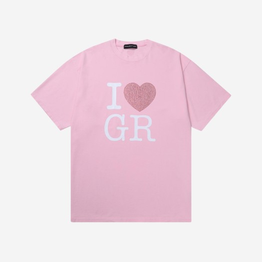
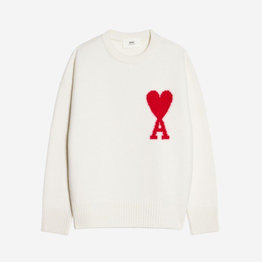
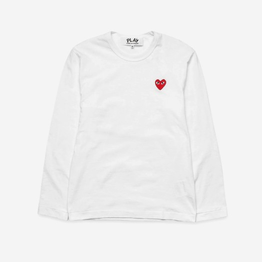
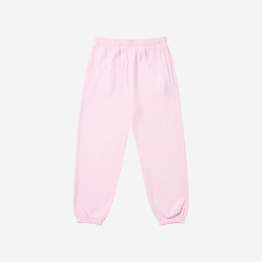
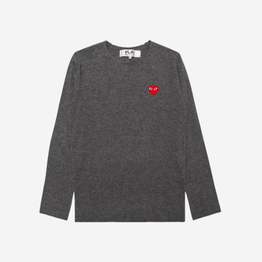





[ Text Embedding Retriever ]
========== Retrieving Query ==========
pink top with heart shape logo
Metadata :
{'metadata': {'ls_embedding_provider': 'OpenAIEmbeddings',
              'ls_retriever_name': 'vectorstore',
              'ls_vector_store_provider': 'Chroma'},
 'name': 'VectorStoreRetriever',
 'parent_run_id': UUID('2d0e4671-2c5e-4617-990c-66aede2ff938'),
 'run_id': UUID('45968abe-dd1e-4c39-8cd8-c5ccda1db1db'),
 'tags': ['seq:step:2', 'Chroma', 'OpenAIEmbeddings']}
========== Retrieving Result ==========
Metadata :
{'parent_run_id': UUID('2d0e4671-2c5e-4617-990c-66aede2ff938'),
 'run_id': UUID('45968abe-dd1e-4c39-8cd8-c5ccda1db1db'),
 'tags': ['seq:step:2', 'Chroma', 'OpenAIEmbeddings']}



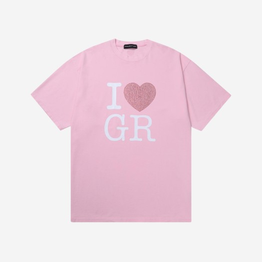
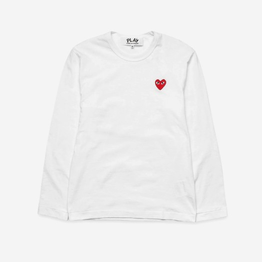
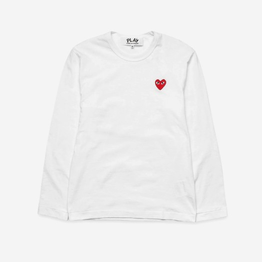
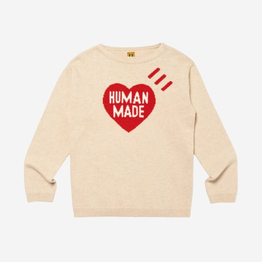
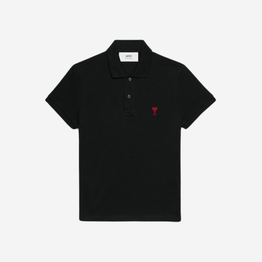





[ Hybrid Retriever ]
========== Retrieving Query ==========
pink top with heart shape logo
Metadata :
{'metadata': {'ls_embedding_provider': 'OpenAIEmbeddings',
              'ls_retriever_name': 'vectorstore',
              'ls_vector_store_provider': 'Chroma'},
 'name': 'VectorStoreRetriever',
 'parent_run_id': UUID('be338a4e-2014-49e8-acfd-a17c723a259d'),
 'run_id': UUID('03bfc598-8b90-4fdd-8bc8-6ff82ffddb6d'),
 'tags': ['seq:step:1', 'Chroma', 'OpenAIEmbeddings']}
========== Retrieving Result ==========
Metadata :
{'parent_run_id': UUID('be338a4e-2014-49e8-acfd-a17c723a259d'),
 'run_id': UUID('03bfc598-8b90-4fdd-8bc8-6ff82ffddb6d'),
 'tags': ['seq:step:1', 'Chroma', 'OpenAIEmbeddings']}



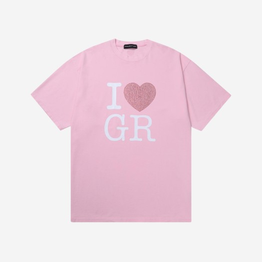
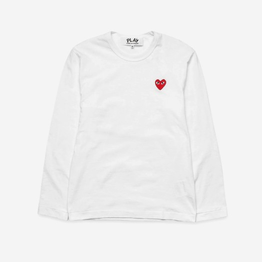
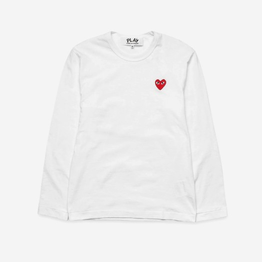
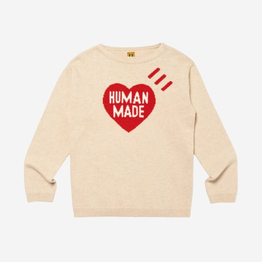
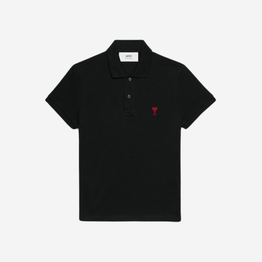

In [102]:
for name, retriever in retrievers:
    print(f"[ {name} ]")
    retriever.invoke(
        "pink top with heart shape logo",
        {"callbacks": [LoggingCallbackHandler(show_metadata=True)]},
    )
    print("\n")
    print("\n")

[ Multimodal Retriever ]
========== Retrieving Query ==========
polo shirt
========== Retrieving Result ==========



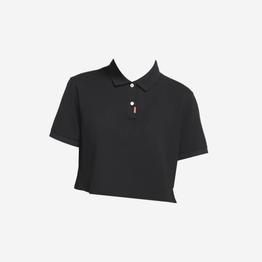
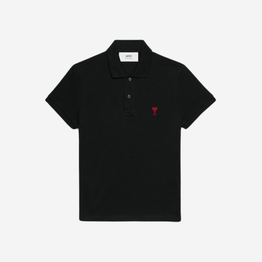
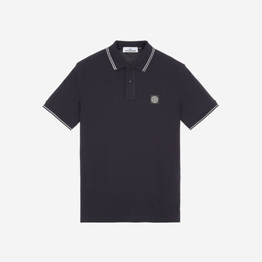
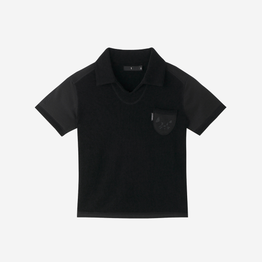
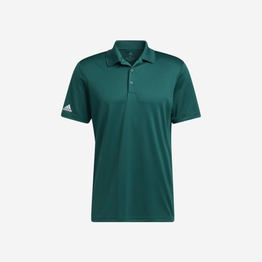





[ Text Embedding Retriever ]
========== Retrieving Query ==========
polo shirt
========== Retrieving Result ==========



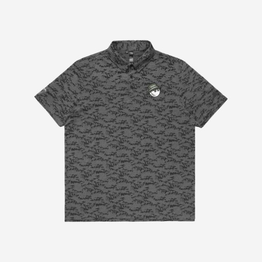
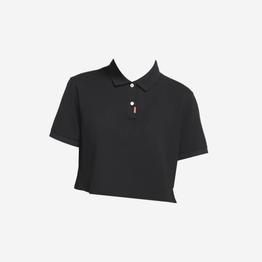
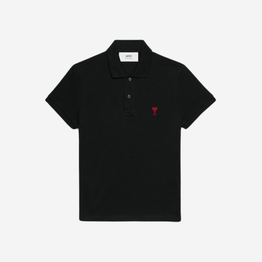
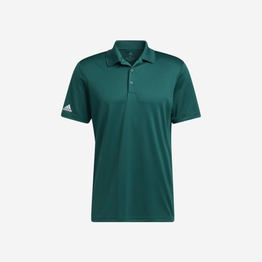
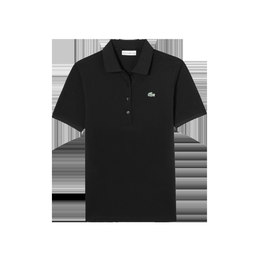





[ Hybrid Retriever ]
========== Retrieving Query ==========
polo shirt
========== Retrieving Result ==========



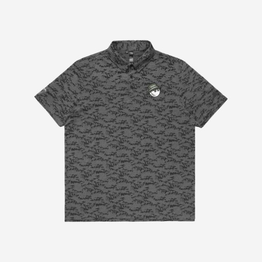
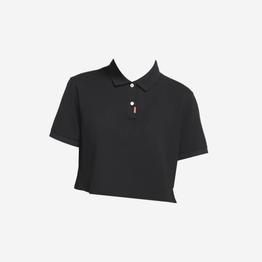
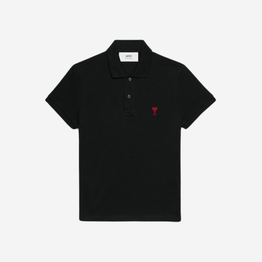
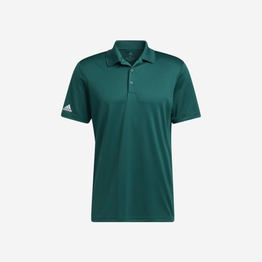
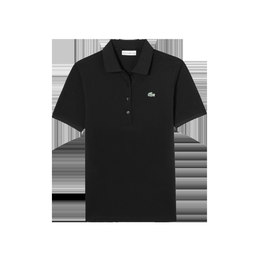

In [88]:
for name, retriever in retrievers:
    print(f"[ {name} ]")
    retriever.invoke(
        "polo shirt",
        {"callbacks": [LoggingCallbackHandler()]},
    )
    print("\n")
    print("\n")

True
False
[ Multimodal Retriever ]
========== Retrieving Query ==========


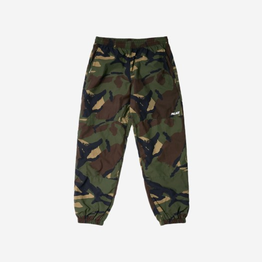

========== Retrieving Result ==========



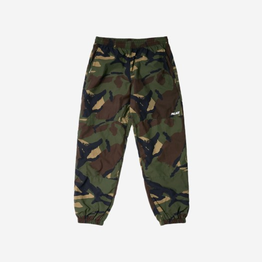
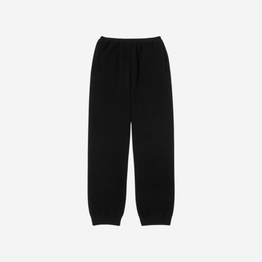
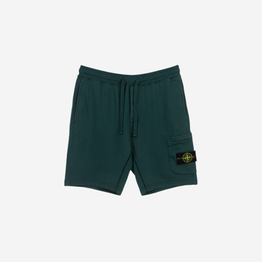
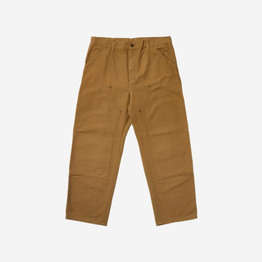
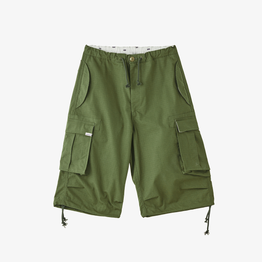





[ Text Embedding Retriever ]
========== Retrieving Query ==========
These are camouflage-patterned jogger pants. They feature an elastic waistband and cuffs for a comfortable fit. The pants are designed with a classic military-inspired camo print, combining shades of green, brown, and black. Perfect for casual wear, they offer a relaxed and sporty style.
========== Retrieving Result ==========



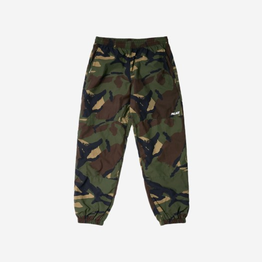
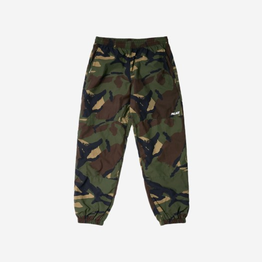
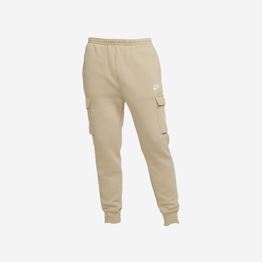
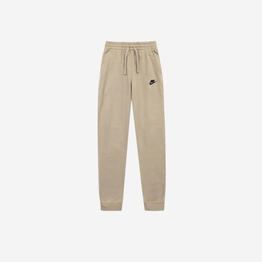
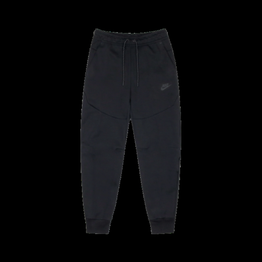





[ Hybrid Retriever ]
========== Retrieving Query ==========


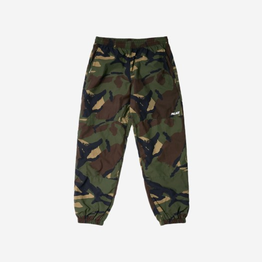

========== Retrieving Result ==========



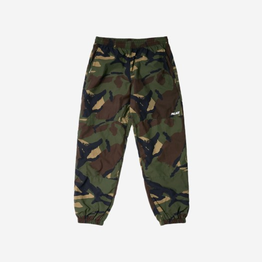
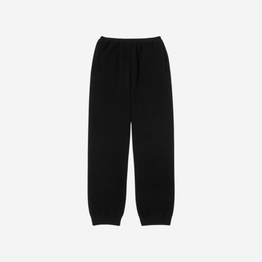
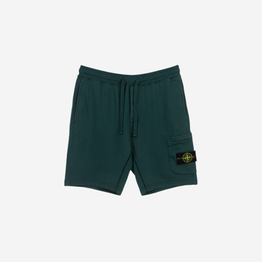
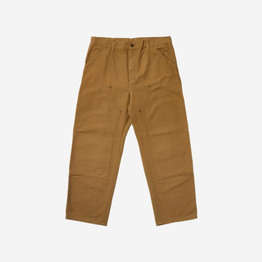
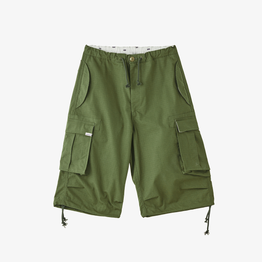

In [90]:
# Use `base64_image` for embedding NOT `base64_image_url`
print(is_base64(database[174]["base64_image"]))
print(is_base64(database[174]["base64_image_url"]))


for name, retriever in retrievers:
    print(f"[ {name} ]")
    retriever.invoke(
        database[174]["base64_image"],
        {"callbacks": [LoggingCallbackHandler()]},
    )
    print("\n")
    print("\n")

[ Multimodal Retriever ]
========== Retrieving Query ==========


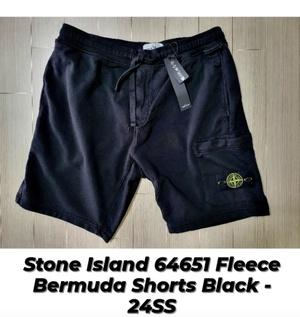

========== Retrieving Result ==========



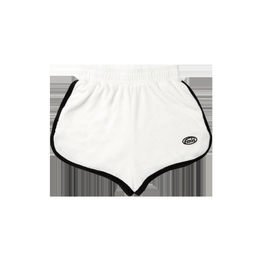
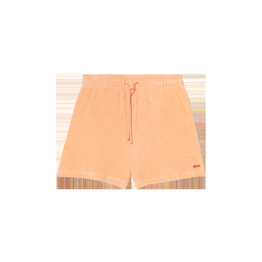
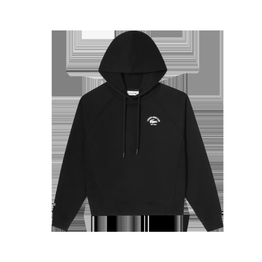
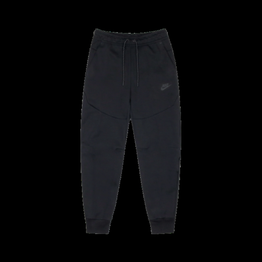
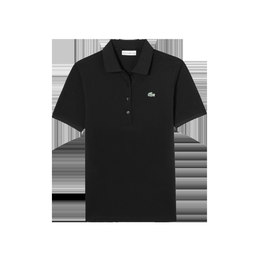





[ Text Embedding Retriever ]
========== Retrieving Query ==========
These are black fleece Bermuda shorts featuring a casual, relaxed design suitable for warm weather. They have a drawstring waistband for an adjustable fit and include a side pocket. The shorts are branded with a patch logo on one side, adding a distinctive style element. Made by Stone Island, these shorts are likely to be both comfortable and stylish, ideal for casual outings.
========== Retrieving Result ==========



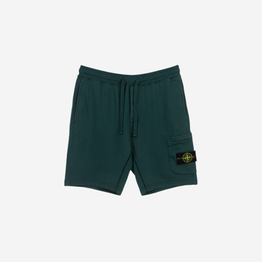
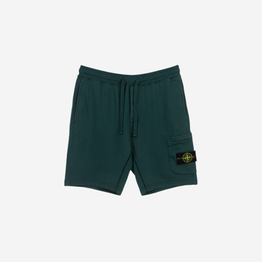
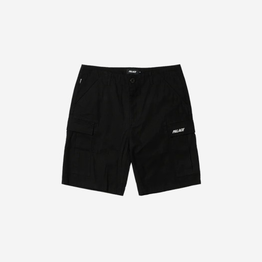
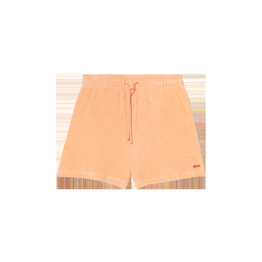
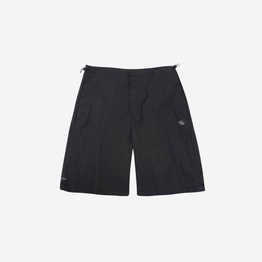





[ Hybrid Retriever ]
========== Retrieving Query ==========


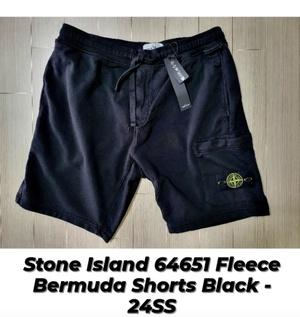

========== Retrieving Result ==========



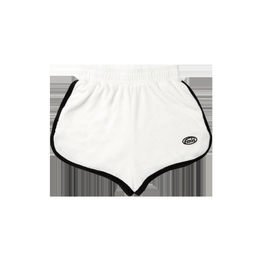
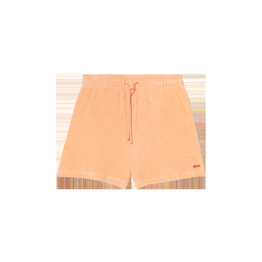
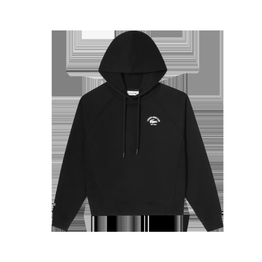
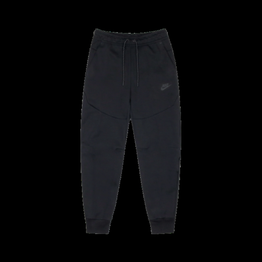
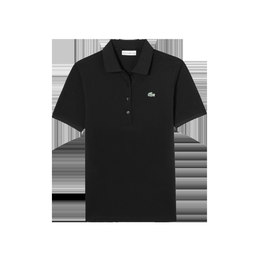





[ Multimodal Retriever ]
========== Retrieving Query ==========


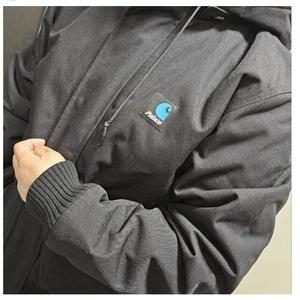

========== Retrieving Result ==========



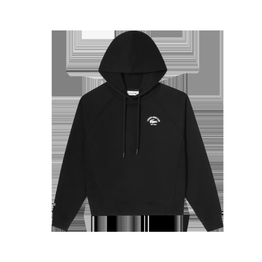
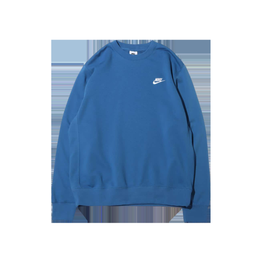
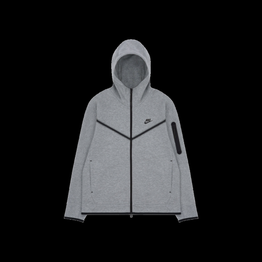
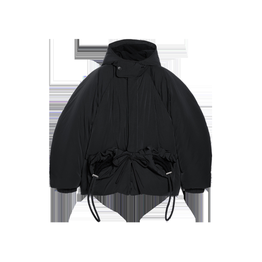
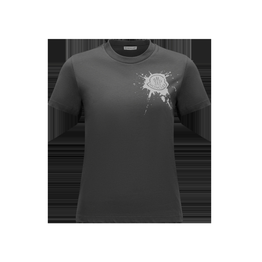





[ Text Embedding Retriever ]
========== Retrieving Query ==========
The image shows a dark-colored jacket. It has a hood and a front zipper closure. There is a logo on the chest area, which appears to be a brand emblem. The jacket has ribbed cuffs, providing a snug fit around the wrists. The material looks durable and suitable for cold weather, suggesting it is designed for warmth and protection against the elements.
========== Retrieving Result ==========



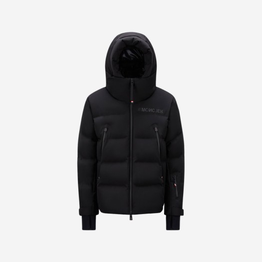
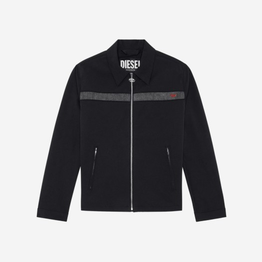
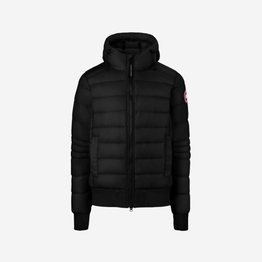
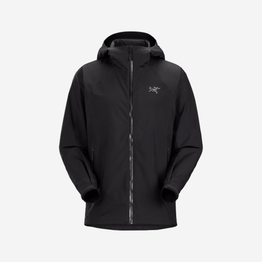
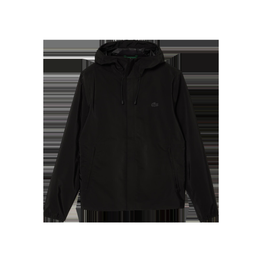





[ Hybrid Retriever ]
========== Retrieving Query ==========


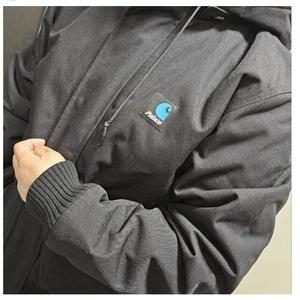

========== Retrieving Result ==========



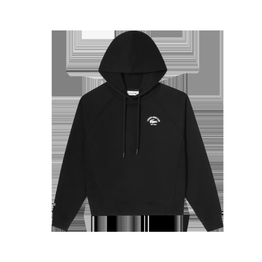
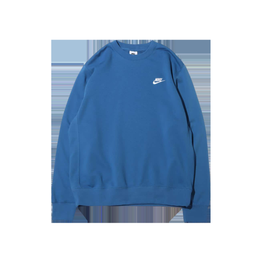
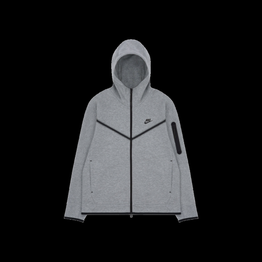
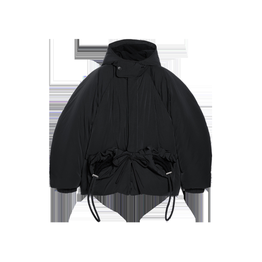
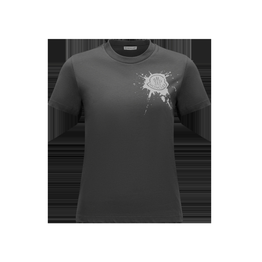





[ Multimodal Retriever ]
========== Retrieving Query ==========


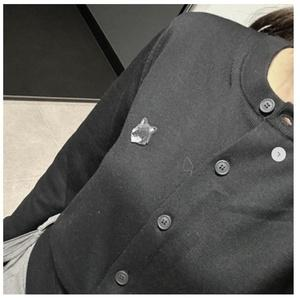

========== Retrieving Result ==========



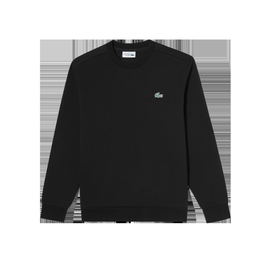
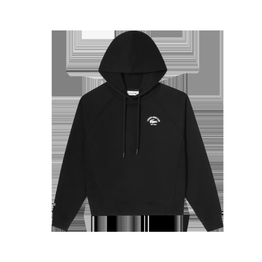
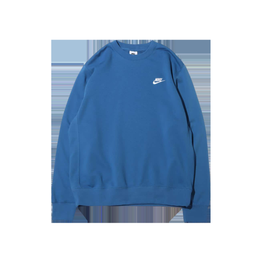
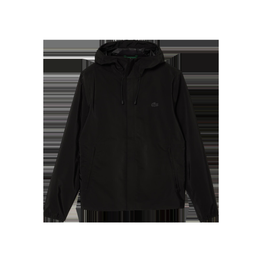
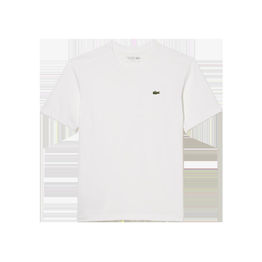





[ Text Embedding Retriever ]
========== Retrieving Query ==========
The image shows a black cardigan with a round neckline and button-down front. It features a small, shiny embellishment on the left side, possibly a pin or brooch. The material appears to be soft, likely a knitted fabric. The cardigan is worn over a light-colored top.
========== Retrieving Result ==========



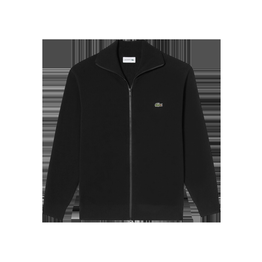
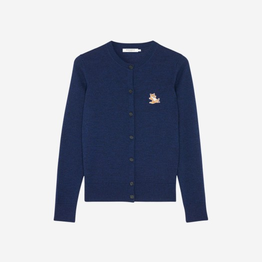
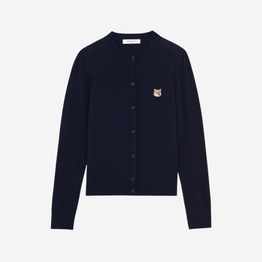
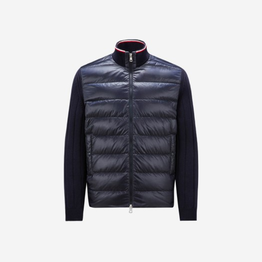
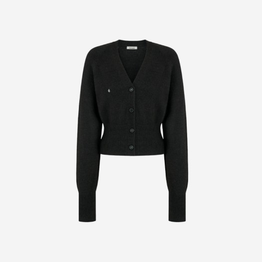





[ Hybrid Retriever ]
========== Retrieving Query ==========


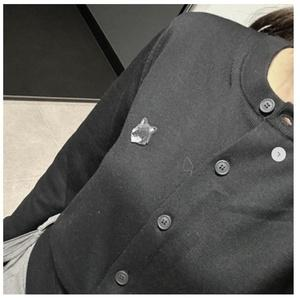

========== Retrieving Result ==========



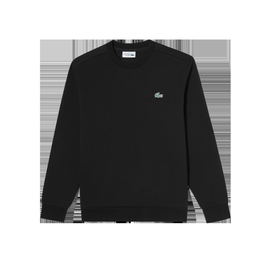
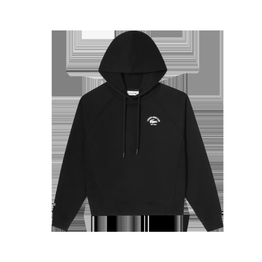
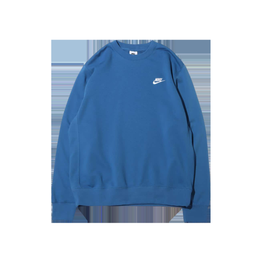
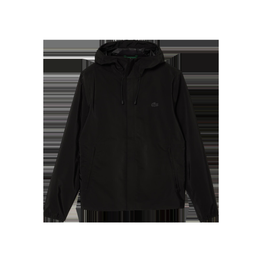
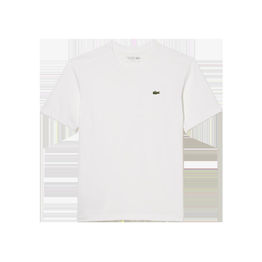

In [101]:
def encode_image_base64_from_file(file_path):
    try:
        with open(file_path, "rb") as img_file:
            image_data = img_file.read()

        image = Image.open(BytesIO(image_data))
        max_size = (2000, 2000)
        image.thumbnail(max_size, Image.Resampling.LANCZOS)

        buffer = BytesIO()
        image.convert("RGB").save(buffer, format="JPEG")
        resized_image_data = buffer.getvalue()

        encoded_image = base64.b64encode(resized_image_data)
        decoded_image = encoded_image.decode("utf8")
        return decoded_image
    except Exception as e:
        print(e)
    return None


for root, dirs, files in os.walk("../assets"):
    for file in files:
        if any(
            file.lower().endswith(ext) for ext in [".jpeg", ".jpg", ".png"]
        ) and file.startswith("11-ShoppingQnA"):
            image = encode_image_base64_from_file(file_path=os.path.join(root, file))
            for name, retriever in retrievers:
                print(f"[ {name} ]")
                retriever.invoke(
                    image,
                    {"callbacks": [LoggingCallbackHandler()]},
                )
                print("\n")
                print("\n")

## Multimodal RAG Chatbot
